In [63]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 22 14:13:15 2023

@author: souchaud
"""
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import sys
import shutil
import functions_analyze as lib
from scipy.signal import find_peaks

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

Device for torch operations: cpu


In [65]:
def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.
    
    Paramètres
    ----------
    dX : Tensor
        Le déplacement des cellules durant le dernier intervalle de temps.
    n : Tensor
        La direction actuelle des cellules.
    tau : float
        Le temps caractéristique pour l'alignement de la polarisation dans
        la direction définie par la vitesse = dX/dt.
    noise : float
        L'intensité du bruit ajouté pour simuler des perturbations aléatoires
        dans la direction des cellules.
    dt : float
        L'intervalle de temps entre les mises à jour des positions.
    persistence : float
        Le facteur de persistance qui influence à quel point la direction actuelle
        est conservée. Valeur entre 0 (pas de persistance, direction entièrement aléatoire)
        et 1 (persistance complète, pas de changement de direction).

    Retour
    -------
    new_dir : Tensor
        La nouvelle direction des cellules après mise à jour.
    """

    # Normalisation de dX
    if torch.norm(dX, dim=1, keepdim=True) > 0 :
        dX_norm = dX / torch.norm(dX, dim=1, keepdim=True)
    else: dX_norm = dX
    # n = n / torch.norm(n, dim=1, keepdim=True)
    # Initialisation de theta basé sur dX, angle entre l'axe des absicce et le vecteur déplacement
    # theta est donc comprie entre -pi et pi.
    theta = torch.atan2(dX_norm[:, 1], dX_norm[:, 0])

    # Génération de bruit
    # rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * np.sqrt(dt) * (1 - persistence)
    rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * np.sqrt(dt)

    # Compute the change in angle based on the orientation vector (n)
    dtheta = 0 * torch.arcsin((n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / tau # * (1 - persistence))

    # Application du bruit à theta pour obtenir le nouvel angle avec l'axe des x
    new_theta = theta + dtheta + rnd[:, 0]
    
    # Calcul des nouvelles composantes de la direction basée sur new_theta
    new_dir_x = torch.cos(new_theta)
    new_dir_y = torch.sin(new_theta)

    # Normalize the new direction vector
    new_dir_norm = torch.sqrt(new_dir_x**2 + new_dir_y**2)
    n[:, 0].copy_(new_dir_x / new_dir_norm)
    n[:, 1].copy_(new_dir_y / new_dir_norm)
    # Calcul de l'angle entre le nouveau n et dX
    # Utilisation de atan2 pour capturer la direction de la rotation dans l'intervalle [-pi, pi]
    angle_entre_vecteur = torch.atan2(n[:, 1], n[:, 0]) - torch.atan2(dX[:, 1], dX[:, 0])
    diff_theta = new_theta - theta
    # diff_theta = (diff_theta + np.pi) % (2 * np.pi) - np.pi
    # Normalisation de l'angle pour s'assurer qu'il est dans l'intervalle [-pi, pi]
    # angle_entre_vecteur = (angle_entre_vecteur + np.pi) % (2 * np.pi) - np.pi

    return n, rnd, dX_norm , diff_theta, angle_entre_vecteur

In [66]:
class CellAgent:
    def __init__(self, id, position, velocity, velocity_magnitude, persistence, space_size):
        # We add the inital position to make some calc later.
        self.id = id
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)
        self.rnd = 0
        self.dtheta = 0
        self.initial_theta = 0
        self.final_theta = 0

class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude, persistence, min_distance):
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        
        # Générez les vitesses initiales selon une distribution gaussienne
        ecart_type_vitesse = 0.9  # À ajuster selon vos besoins
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=ecart_type_vitesse, size=(self.num_cells,))
        # Créer vitesses_gaussiennes avec la même forme que la sortie de torch.normal()
        vitesses_gaussiennes = torch.full((self.num_cells,), self.velocity_magnitude)
        # Appliquez les vitesses gaussiennes aux directions pour obtenir les vecteurs de vitesse
        velocities = directions * vitesses_gaussiennes[:, None]

        if self.min_distance != 0:
          # Create a grid with cell size equal to the minimum distance
          grid_size = int(np.ceil(self.space_size / self.min_distance))
          grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]

          valid_positions = []
          for i in range(self.num_cells):
              valid = True

              # Compute the cell's grid indices
              grid_x = int(positions[i, 0] / self.min_distance)
              grid_y = int(positions[i, 1] / self.min_distance)

              # Check neighboring cells in the grid
              for dx in [-1, 0, 1]:
                  for dy in [-1, 0, 1]:
                      nx = grid_x + dx
                      ny = grid_y + dy

                      # Check if the neighboring grid cell is valid
                      if 0 <= nx < grid_size and 0 <= ny < grid_size:
                          for cell_pos in grid[nx][ny]:
                              # Check the distance between the current cell and the neighboring cells
                              if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                  valid = False
                                  break
                      if not valid:
                          break
                  if not valid:
                      break
              if valid:
                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
              else:
                  # Generate a new random position until a valid one is found
                  while not valid:
                      positions[i] = torch.rand((1, 2), device=device) * self.space_size

                      # Compute the updated cell's grid indices
                      grid_x = int(positions[i, 0] / self.min_distance)
                      grid_y = int(positions[i, 1] / self.min_distance)

                      # Check neighboring cells in the grid
                      valid = True
                      for dx in [-1, 0, 1]:
                          for dy in [-1, 0, 1]:
                              nx = grid_x + dx
                              ny = grid_y + dy

                              # Check if the neighboring grid cell is valid
                              if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                  for cell_pos in grid[nx][ny]:
                                      # Check the distance between the current cell and the neighboring cells
                                      if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                          valid = False
                                          break
                              if not valid:
                                  break
                          if not valid:
                              break

                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
        else :
          valid_positions = [positions[i] for i in range(len(positions))]

        # self.cells = [CellAgent(position, velocities[i], self.velocity_magnitude, self.persistence, self.space_size) for i, position in enumerate(valid_positions)]
        self.cells = [CellAgent(position, directions[i] * vitesses_gaussiennes[i], vitesses_gaussiennes[i], self.persistence, self.space_size) for i, position in enumerate(positions)]

        for i in range(self.num_cells):
            id = i  # Identifiant unique pour chaque cellule
            position = positions[i]
            direction = directions[i]  # Assurez-vous d'avoir la direction correcte ici
            self.cells.append(CellAgent(id, position, direction, self.velocity_magnitude, self.persistence, self.space_size))
            
class Surface:
    def get_friction(self, position):
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()

In [67]:
# In[Simulation parameters]
# Space parameters
SPACE_SIZE = 2048 #1308 # Micrometers

# time settings
TIME_SIMU = 10 # time simulation in minutes
DELTA_T = 0.01 # 15/60 # 0.01 # simulation interval in minutes
PLOT_INTERVAL = 100 # 25

# simulation parameters
MU = 0 #1  # mobility in min.kg-1
R_EQ = 1.1
MIN_DISTANCE_INIT = R_EQ

# factor simulation
NOISE = 5 #10 # noise intensity
FLUCTUATION_FACTOR = 0 #4
TAU = 5 # 5 # characteristic time for the polarization to align in the scattering direction defined by v=dr/dt = time
PERSISTENCE_POP1 = 0 #0.1
PERSISTENCE_POP2 = 0 #0.4

# Cells definition
PACKING_FRACTION = 0.00002
N_CELLS = int((PACKING_FRACTION*SPACE_SIZE**2)/
              (math.pi*((R_EQ/2)**2)))  # number of particles
print(N_CELLS, "cells")
velocity_magnitude_pop1 = 5 #um/min
velocity_magnitude_pop2 = 5 # um/min

# In[Definition of the populations]
population1 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop1,\
                         persistence=PERSISTENCE_POP1,\
                         min_distance=MIN_DISTANCE_INIT)

population2 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop2,\
                         persistence=PERSISTENCE_POP2,\
                         min_distance=MIN_DISTANCE_INIT)

cells = population1.cells + population2.cells

surface = Surface()

# In[initialisation]
positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device = device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])


# In[Simulation]
# Création du DataFrame vide
columns = ['frame', 'particle', 'x', 'y', 'dir_x', 'dir_y', 'initial_theta', 'rnd', 'dX_x', 'dX_y', 'final_theta']
data_frame = pd.DataFrame(columns=columns)
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2*(SPACE_SIZE/2)**2)

while time < TIME_SIMU :
    #Paiwise distance.
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff-(SPACE_SIZE/2),SPACE_SIZE)-(SPACE_SIZE/2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
                             for i in range(0, len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
      print("At least one distance is greater than the max distance.")
    
    # displacement computing
    fluctuations = (torch.rand(V0.shape, device=V0.device) - 0.5) * FLUCTUATION_FACTOR
    displacement = (V0 + fluctuations) * direction * DELTA_T
    
    # cells position evolution
    positions += displacement

    # border conditions
    positions = torch.remainder(positions, SPACE_SIZE)

    for cell, position, direct in zip(cells, positions, direction):
        cell.position = position.to(device)
        cell.direction = direct.to(device)
        # print(cell, position, direct)

    for i, cell in enumerate(population1.cells):
        # Extraire le vecteur déplacement spécifique à cette cellule
        cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
        # Appeler autovel et récupérer la nouvelle direction et l'angle
        new_direction, rnd, dX_norm, initial_theta, final_theta = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
        # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
        cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue
        cell.rnd = rnd.item()
        cell.dtheta = dX_norm.squeeze(0)#dtheta.item()
        cell.initial_theta = initial_theta.item()
        cell.final_theta = final_theta.item()

    # Faire de même pour la population 2
    for i, cell in enumerate(population2.cells):
        # Extraire le déplacement spécifique à cette cellule
        cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
        # Appeler autovel et récupérer la nouvelle direction et l'angle
        new_direction, rnd, dX_norm, initial_theta, final_theta = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
        # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
        cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue
        cell.rnd = rnd.item()
        cell.dtheta = dX_norm.squeeze(0)#dtheta.item()
        cell.initial_theta = initial_theta.item()
        cell.final_theta = final_theta.item()

    # plot the result
    # # Concaténez ce DataFrame temporaire avec le DataFrame principal
    temp_data = []
    for i, cell in enumerate(cells):
        temp_data.append([
            time, i, cell.position[0].item(), cell.position[1].item(), 
            cell.direction[0].item(), cell.direction[1].item(), 
            cell.initial_theta, cell.rnd, cell.dtheta[0].item(), cell.dtheta[1].item(), cell.final_theta # Enregistrez les nouvelles valeurs ici
        ])

    temp_df = pd.DataFrame(temp_data, columns=['frame', 'particle', 'x', 'y', 'dir_x', 'dir_y', 'initial_theta', 'rnd', 'dX_x', 'dX_y', 'final_theta'])
    data_frame = pd.concat([data_frame, temp_df], ignore_index=True)
    # Après avoir mis à jour toutes les cellules
    direction = torch.stack([cell.direction for cell in cells])
    # Mise à jour du temps
    time += DELTA_T
    # print(time)
    iteration += 1

88 cells


TypeError: CellAgent.__init__() missing 1 required positional argument: 'space_size'

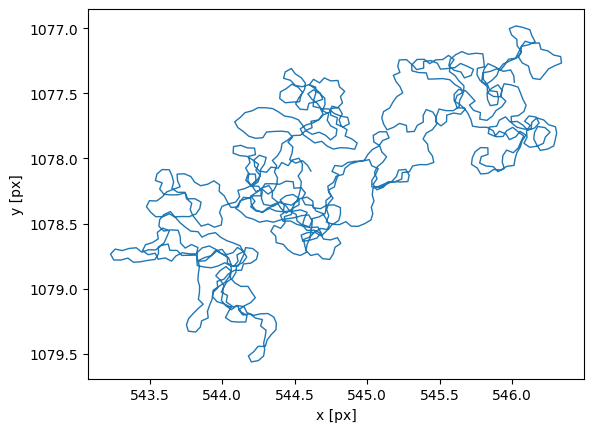

In [ ]:
import trackpy as tp
tp.plot_traj(data_frame[data_frame['particle']==1])
data_frame.groupby('particle')

In [ ]:
def adjust_positions_xy(group):
    SPACE_SIZE_X = SPACE_SIZE  # La taille de l'espace toroïdal en x
    SPACE_SIZE_Y = SPACE_SIZE  # La taille de l'espace toroïdal en y, ajustez selon votre espace
    # Calculer les différences pour obtenir 'dx' et 'dy'
    group['dx'] = group['x'].diff().fillna(0)
    group['dy'] = group['y'].diff().fillna(0)
    
    # Initialiser de nouvelles colonnes pour les positions ajustées
    group['adjusted_x'] = group['x'].copy()
    group['adjusted_y'] = group['y'].copy()
    
    # Ajuster les positions en x
    for i in range(1, len(group)):
        if group.iloc[i]['dx'] > SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] -= SPACE_SIZE_X
        elif group.iloc[i]['dx'] < -SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] += SPACE_SIZE_X
            
    # Ajuster les positions en y
    for i in range(1, len(group)):
        if group.iloc[i]['dy'] > SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] -= SPACE_SIZE_Y
        elif group.iloc[i]['dy'] < -SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] += SPACE_SIZE_Y
            
    # Calculer dx et dy ajustés après correction
    group['adjusted_dx'] = group['adjusted_x'].diff().fillna(0)
    group['adjusted_dy'] = group['adjusted_y'].diff().fillna(0)
    
    return group

# Assurez-vous que votre DataFrame df_final contient une colonne 'y' pour chaque position y
# Par exemple, ajouter: df_final['y'] = [valeur_y1, valeur_y2, ...] pour chaque particule

# Appliquer la fonction à chaque groupe de particules et concaténer les résultats
df_adjusted = data_frame.groupby('particle').apply(adjust_positions_xy).reset_index(drop=True)

df_adjusted['x'] = df_adjusted['adjusted_x']
df_adjusted['y'] = df_adjusted['adjusted_y']


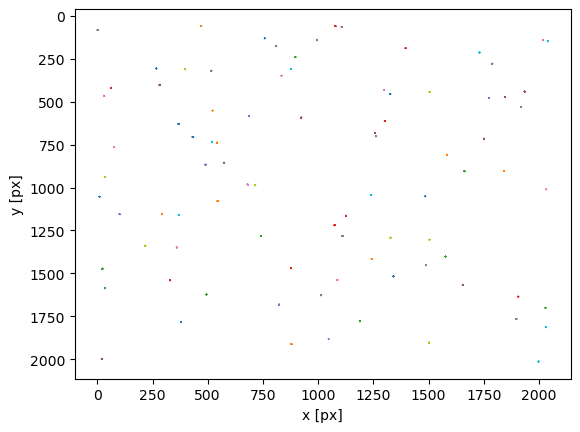

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [ ]:
tp.plot_traj(traj=df_adjusted)

In [ ]:
df_adjusted.drop(['adjusted_x', 'adjusted_y', 'adjusted_dx', 'adjusted_dy'], axis=1, inplace=True)

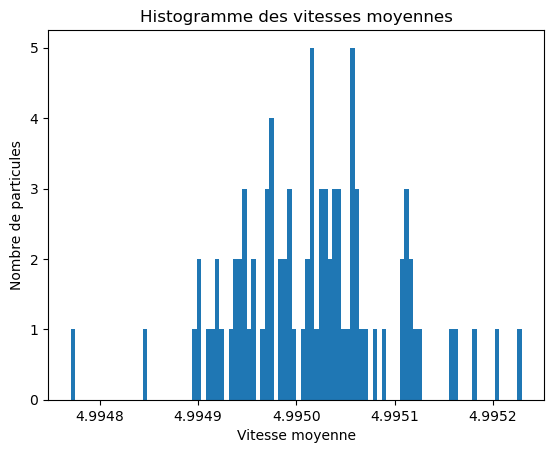

In [ ]:
# Calculer les différences de position
df_adjusted['dx'] = df_adjusted.groupby('particle')['x'].diff().fillna(0)
df_adjusted['dy'] = df_adjusted.groupby('particle')['y'].diff().fillna(0)

# Calculer la distance parcourue à chaque pas de temps
df_adjusted['distance'] = (df_adjusted['dx']**2 + df_adjusted['dy']**2).pow(0.5)

# Calculer la vitesse pour chaque pas de temps
df_adjusted['vitesse'] = df_adjusted['distance'] / DELTA_T

# Calculer la vitesse moyenne pour chaque particule
vitesse_moyenne = df_adjusted.groupby('particle')['vitesse'].mean()

# Tracer l'histogramme des vitesses moyennes
plt.hist(vitesse_moyenne, bins=100)

# Ajuster les limites de l'axe x pour correspondre à la plage de l'histogramme
# plt.xlim(4, 6)

# Ajouter des titres et des étiquettes
plt.title('Histogramme des vitesses moyennes')
plt.xlabel('Vitesse moyenne')
plt.ylabel('Nombre de particules')

# Afficher l'histogramme
plt.show()

In [ ]:
# Fonction pour calculer l'angle en degrés entre deux vecteurs de direction successifs
def angle_between_directions(row):
    # Extract direction components
    dx1, dy1 = row['dir_x'], row['dir_y']
    dx2, dy2 = row['dir_x_next'], row['dir_y_next']
    
    # Calculate initial and final angles using arctan2 for each direction vector
    angle_initial = np.arctan2(dy1, dx1)
    angle_final = np.arctan2(dy2, dx2)
    
    # Calculate the angle difference
    angle_change = angle_final - angle_initial
    
    # Normalize the angle to be between -pi and pi
    angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))
    # if angle_change > 1.49 and angle_change < 1.51:
    #     print(row)
    return angle_change
#     # return np.degrees(angle_change)  # Convert angle to degrees
#     # Calculate the angle difference
#     angle_change = np.arccos(dx1*dx2+dy1*dy2)
#     # Normalize the angle to be between -pi and pi
#     # angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))
df = df_adjusted.copy()
# Assurez-vous que votre DataFrame est trié par particule et par frame
df.sort_values(by=['particle', 'frame'], inplace=True)

# Décaler les directions pour obtenir le vecteur direction au temps t+1 pour chaque particule
df['dir_x_next'] = df.groupby('particle')['dir_x'].shift(-1)
df['dir_y_next'] = df.groupby('particle')['dir_y'].shift(-1)

# Appliquer la fonction pour calculer l'angle entre les directions successives
df['angle_change'] = df.apply(angle_between_directions, axis=1)

# Optionnel : Supprimer les lignes où la direction suivante est NaN, ce qui se produit pour la dernière observation de chaque particule
df.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

# Afficher le résultat
# print(df[['frame', 'particle', 'dir_x', 'dir_y', 'dir_x_next', 'dir_y_next', 'angle_change']])


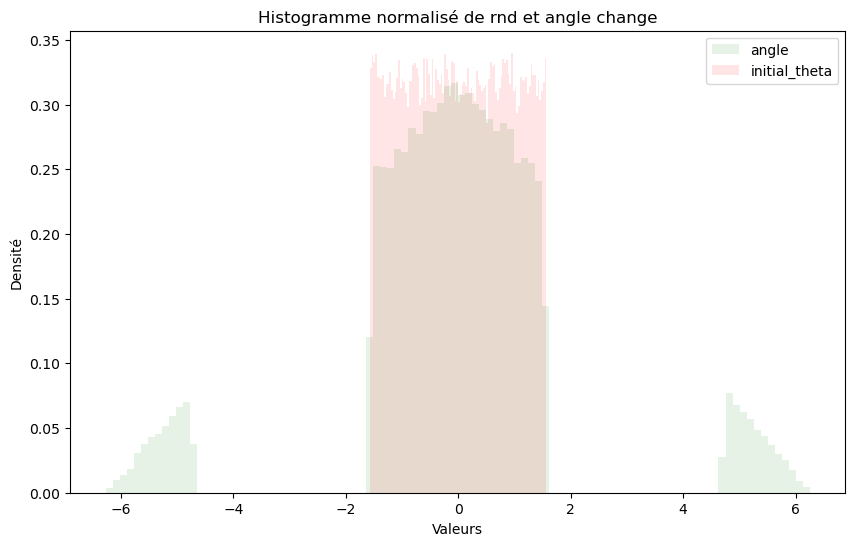

In [ ]:
# Créer une nouvelle figure
plt.figure(figsize=(10, 6))
plt.hist(df['final_theta'], bins=100, alpha=0.1, color='green', label='angle', density=True)
plt.hist(df['initial_theta'], bins=100, alpha=0.1, color='red', label='initial_theta', density=True)
# plt.hist(df['final_theta'], bins=100, alpha=0.1, color='yellow', label='final_theta', density=True)
# plt.hist(df['dtheta'], bins=100, alpha=0.5, color='green', label='angle', density=True)

# Tracer l'histogramme pour 'angle_change' (normalisé)
# plt.hist(df['angle_change'], bins=100, alpha=0.1, color='blue', label='angle_change', density=True)

# Ajouter une légende
plt.legend()

# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Histogramme normalisé de rnd et angle change')

# Afficher la figure
plt.show()


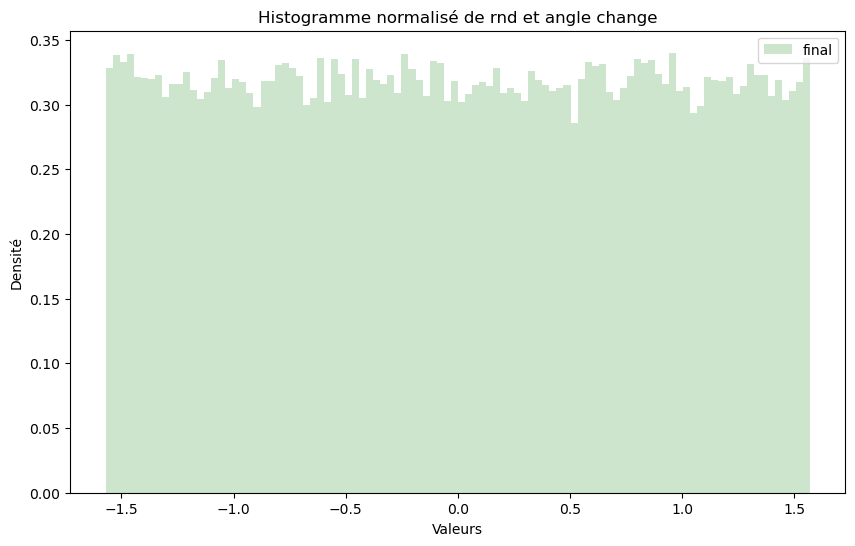

In [ ]:
# Créer une nouvelle figure
plt.figure(figsize=(10, 6))
plt.hist(df['initial_theta'], bins=100, alpha=0.2, color='green', label='final', density=True)
# plt.hist(df['initial_theta'], bins=100, alpha=0.2, color='red', label='initial', density=True)
# plt.hist(df['final_theta'], bins=100, alpha=0.2, color='blue', label='angle', density=True)
# plt.hist(df['initial_theta'], bins=100, alpha=0.2, color='green', label='angle', density=True)



# Tracer l'histogramme pour 'angle_change' (normalisé)
# plt.hist(df['angle_change'], bins=100, alpha=0.2, color='blue', label='angle_change', density=True)

# Ajouter une légende
plt.legend()

# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Histogramme normalisé de rnd et angle change')

# Afficher la figure
plt.show()


In [ ]:
df

,frame,particle,x,y,dir_x,dir_y,initial_theta,rnd,dX_x,dX_y,final_theta,dx,dy,distance,vitesse,dir_x_next,dir_y_next,angle_change
0,0,0,365.729797,627.251526,-0.068162,-0.997674,1.501664,1.501664,-1.000000,-0.000917,1.501664,0.000000,0.000000,0.000000,0.000000,-0.862529,-0.506007,-0.972032
1,0.01,0,365.726379,627.201660,-0.862529,-0.506007,-0.972032,-0.972032,-0.068162,-0.997674,-0.972032,-0.003418,-0.049866,0.049983,4.998273,-0.572891,-0.819632,0.430219
2,0.02,0,365.683258,627.176331,-0.572891,-0.819632,0.430219,0.430219,-0.862529,-0.506007,0.430219,-0.043121,-0.025330,0.050010,5.001038,-0.147567,-0.989052,0.461920
3,0.03,0,365.654602,627.135376,-0.147567,-0.989052,0.461920,0.461920,-0.572891,-0.819632,0.461920,-0.028656,-0.040955,0.049984,4.998445,0.760106,-0.649799,1.011585
4,0.04,0,365.647217,627.085938,0.760106,-0.649799,1.011585,1.011585,-0.147567,-0.989052,1.011585,-0.007385,-0.049438,0.049987,4.998705,0.999983,-0.005759,0.701561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88082,9.95,87,1916.956787,528.247253,0.490021,-0.871711,-1.236524,-1.236524,0.984228,0.176905,-1.236524,-0.014771,0.047791,0.050021,5.002102,0.163057,0.986617,2.465691
88083,9.96,87,1916.981323,528.203674,0.163057,0.986617,0.358909,0.358909,0.499219,0.866476,0.358909,0.024536,-0.043579,0.050012,5.001160,0.546442,0.837497,-0.414322
88084,9.97,87,1916.989502,528.252991,0.546442,0.837497,0.761315,0.761315,0.973353,0.229312,0.761315,0.008179,0.049316,0.049990,4.998999,0.031500,0.999504,0.546605
88085,9.98,87,1917.016846,528.294861,0.031500,0.999504,1.284677,1.284677,0.967761,0.251872,1.284677,0.027344,0.041870,0.050008,5.000787,0.953829,0.300350,-1.234231


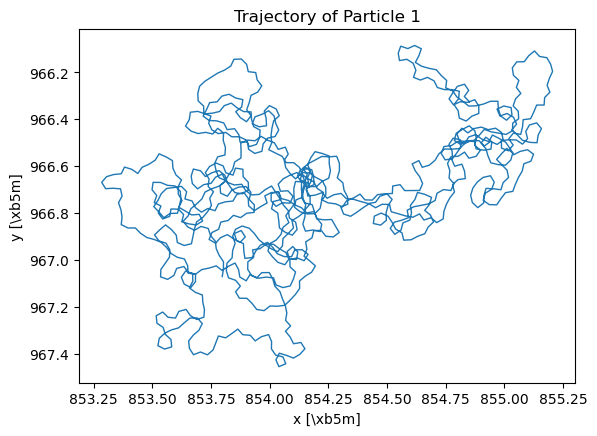

In [ ]:
# Supposons que df_adjusted est votre DataFrame après ajustements avec 'particle', 'x', et 'y'
particle_df = df_adjusted[df_adjusted['particle'] == 20]
fig, ax = plt.subplots()
tp.plot_traj(particle_df, mpp=0.637, fps=1, ax=ax)
# Rendre les échelles des axes x et y égales
ax.set_aspect('equal', 'box')
# Ajouter un titre
ax.set_title('Trajectory of Particle 1')
plt.show()

In [ ]:
df_adjusted[df_adjusted['particle'] == 9]

,frame,particle,x,y,dir_x,dir_y,initial_theta,rnd,dX_x,dX_y,final_theta,dx,dy,distance,vitesse
9009,0,9,2042.023926,146.902252,0.015065,-0.999887,-1.131029,-1.131029,0.911162,-0.412049,-1.131029,0.000000,0.000000,0.000000,0.000000
9010,0.01,9,2042.024658,146.852264,0.410042,-0.912067,0.407434,0.407434,0.015065,-0.999887,0.407434,0.000732,-0.049988,0.049993,4.999316
9011,0.02,9,2042.045166,146.806656,0.962966,0.269624,1.421300,1.421300,0.410042,-0.912067,1.421300,0.020508,-0.045609,0.050007,5.000707
9012,0.03,9,2042.093262,146.820145,0.999268,-0.038266,-0.311278,-0.311278,0.962966,0.269624,-0.311278,0.048096,0.013489,0.049951,4.995141
9013,0.04,9,2042.143188,146.818237,0.788598,-0.614909,-0.623995,-0.623995,0.999268,-0.038266,-0.623995,0.049927,-0.001907,0.049963,4.996318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10005,9.96,9,2038.359375,144.933411,0.996941,-0.078154,0.218503,0.218503,0.956296,-0.292401,0.218503,0.047852,-0.014618,0.050035,5.003454
10006,9.97,9,2038.409180,144.929504,0.023498,-0.999724,-1.469063,-1.469063,0.996941,-0.078154,-1.469063,0.049805,-0.003906,0.049958,4.995764
10007,9.98,9,2038.410400,144.879517,-0.195012,-0.980801,-0.219769,-0.219769,0.023498,-0.999724,-0.219769,0.001221,-0.049988,0.050003,5.000270
10008,9.99,9,2038.400635,144.830475,0.904427,-0.426629,1.326303,1.326303,-0.195012,-0.980801,1.326303,-0.009766,-0.049042,0.050005,5.000460
